## Imports

In [11]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.datasets import cifar100
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Dropout, Input, MaxPool2D, BatchNormalization, add
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam

## Dataset

In [15]:
# cargar dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# labels de animales
animal_labels = [1, 3, 4, 6, 7, 14, 15, 18, 19, 21, 24, 26, 27, 30, 31, 32,
                 34, 36, 38, 42, 43, 44, 45, 50, 55, 63, 64, 65, 66, 67, 72,
                 73, 75, 77, 78, 79, 80, 88, 91, 93, 95, 97, 99]

# escoger solo imagenes de animales
x_train = x_train[np.isin(y_train, animal_labels).flatten()]
x_test = x_test[np.isin(y_test, animal_labels).flatten()]

# mezclar las imagenes
np.random.shuffle(x_train)
np.random.shuffle(x_test)
x_train = x_train / 255
x_test = x_test / 255
print("Dataset de entrenamiento:", x_train.shape)

Dataset de entrenamiento: (21500, 32, 32, 3)


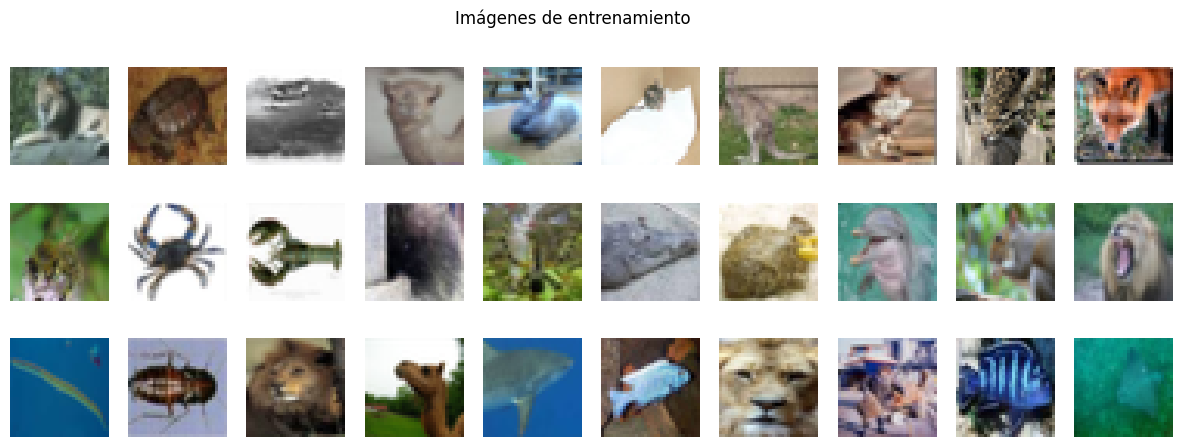

In [27]:
def show(images, title):
    fig, axes = plt.subplots(3, 10, figsize=(15, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.axis('off')

    plt.suptitle(title)
    plt.show()

show(x_train, "Imágenes de entrenamiento")

### Salt and Pepper

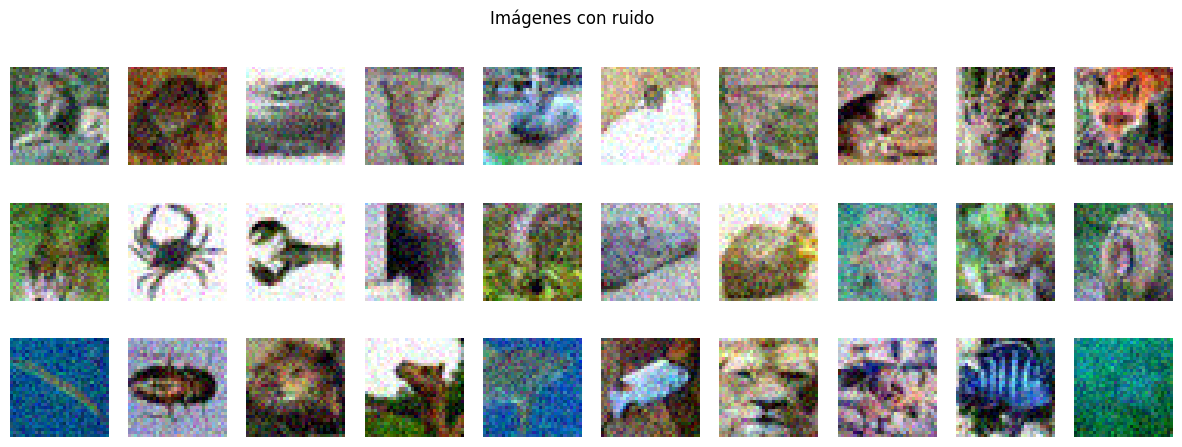

In [28]:
# Adding noise mean = 0, std = 0.3
noise = 0.3
x_train_noisy = x_train + noise * np.random.normal(0, 0.3, size=x_train.shape)
x_test_noisy = x_test + noise * np.random.normal(0, 0.3, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0, 1)
x_test_noisy = np.clip(x_test_noisy, 0, 1)

show(x_train_noisy, "Imágenes con ruido")

## Arquitectura

In [13]:
# Encoder
size = 32
channel = 3

inputs = Input(shape=(size,size,channel))

x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPool2D()(x)
x = Dropout(0.5)(x)
skip = Conv2D(32, 3, padding='same')(x) # skip connection for decoder
x = LeakyReLU()(skip)
x = BatchNormalization()(x)
x = MaxPool2D()(x)
x = Dropout(0.5)(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPool2D()(x)

# Decoder
x = Conv2DTranspose(64, 3,activation='relu',strides=(2,2), padding='same')(encoded)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Conv2DTranspose(32, 3, activation='relu',strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Conv2DTranspose(32, 3, padding='same')(x)
x = add([x,skip]) # adding skip connection
x = LeakyReLU()(x)
x = BatchNormalization()(x)
decoded = Conv2DTranspose(3, 3, activation='sigmoid',strides=(2,2), padding='same')(x)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

## Entrenamiento

In [20]:
# Training
epochs = 25
batch_size = 256

history = autoencoder.fit(x_train_noisy,
                x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_split=0.1
                )

Epoch 1/25
76/76 [==============================] - 20s 40ms/step - loss: 0.6020 - val_loss: 0.6318
Epoch 2/25
76/76 [==============================] - 2s 26ms/step - loss: 0.5646 - val_loss: 0.6210
Epoch 3/25
76/76 [==============================] - 2s 28ms/step - loss: 0.5601 - val_loss: 0.6044
Epoch 4/25
76/76 [==============================] - 2s 28ms/step - loss: 0.5583 - val_loss: 0.5858
Epoch 5/25
76/76 [==============================] - 2s 30ms/step - loss: 0.5573 - val_loss: 0.5733
Epoch 6/25
76/76 [==============================] - 2s 28ms/step - loss: 0.5565 - val_loss: 0.5648
Epoch 7/25
76/76 [==============================] - 2s 27ms/step - loss: 0.5558 - val_loss: 0.5576
Epoch 8/25
76/76 [==============================] - 2s 27ms/step - loss: 0.5554 - val_loss: 0.5546
Epoch 9/25
76/76 [==============================] - 2s 27ms/step - loss: 0.5551 - val_loss: 0.5513
Epoch 10/25
76/76 [==============================] - 2s 27ms/step - loss: 0.5548 - val_loss: 0.5504
Epoch 11

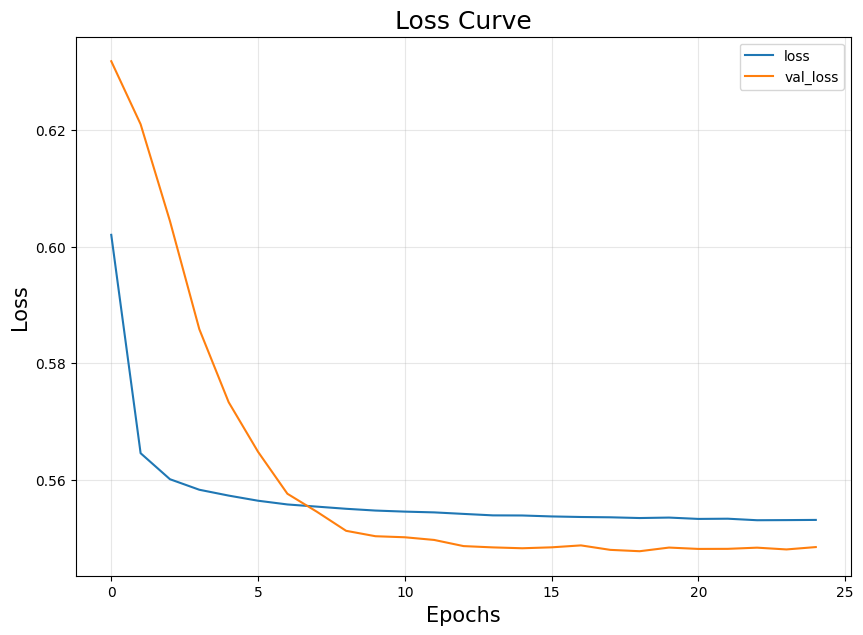

In [21]:
# Defining Figure
f = plt.figure(figsize=(10,7))
f.add_subplot()

#Adding Subplot
plt.plot(history.epoch, history.history['loss'], label = "loss") # Loss curve for training set
plt.plot(history.epoch, history.history['val_loss'], label = "val_loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

## Predict

1/1 [==============================] - 0s 36ms/step


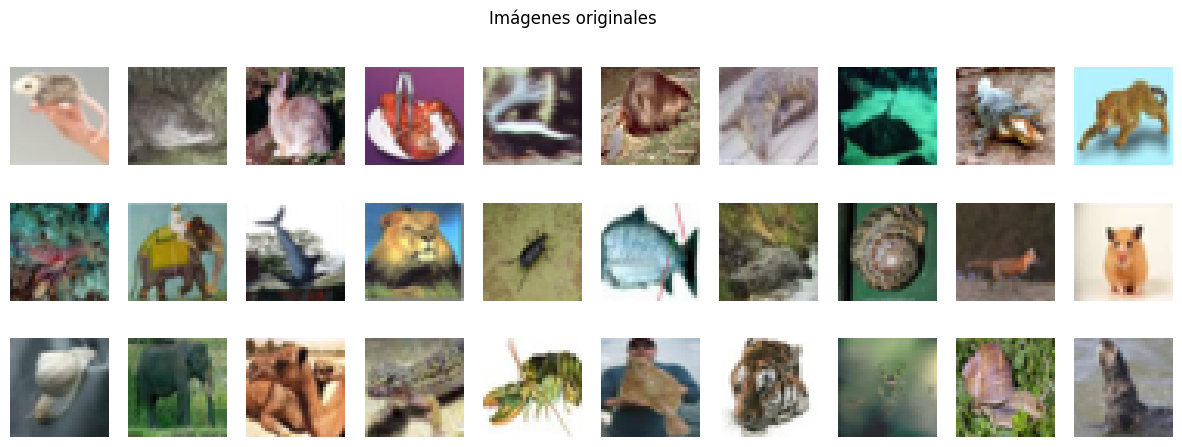

In [29]:
# pick 30 random indices
random_indices = random.sample(range(len(x_test_noisy)), 30)

# select the corresponding images from X and x_test_noisy
test_images = x_test_noisy[random_indices]
original_images = x_test[random_indices]

cifar_test_denoised = autoencoder.predict(test_images)

# display the images using the show function
show(original_images, "Imágenes originales")

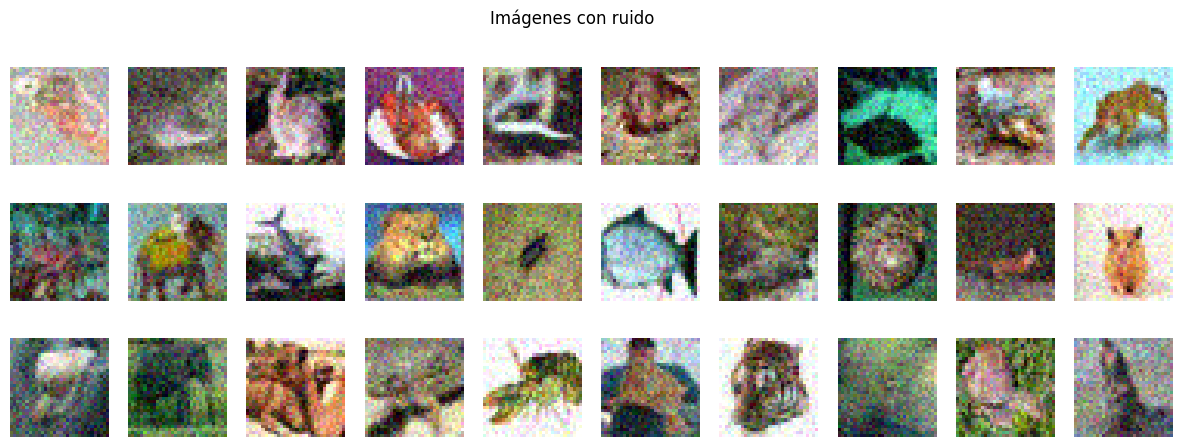

In [30]:
show(test_images, "Imágenes con ruido")

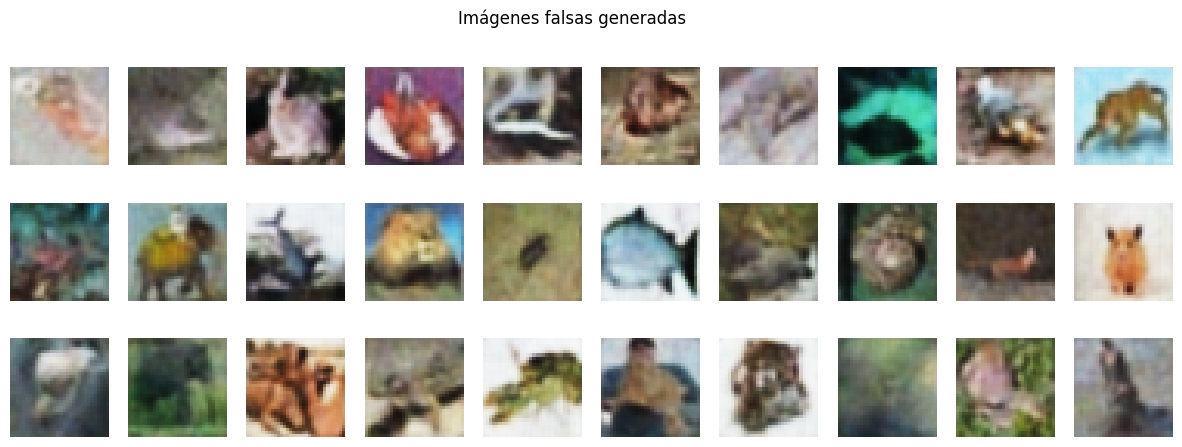

In [31]:
show(cifar_test_denoised, "Imágenes falsas generadas")